# MeerKAT Proposal Reviewer Allocation Problem

Richard Armstrong June 2022

Solve the Reviewer Assignment Problem for a set of MeerKAT Proposals

REQUIREMENTS
* Reviewers must have between 10 and 20 proposals to review 
* Proposals are reviewed 4 times each (`coverage`)
* Must exclude reviewers from reviewing proposals they are involved in

In [3]:
#!pip install --upgrade pip
#!pip install numpy matplotlib pandas openpyxl cvxopt

In [4]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from numpy import genfromtxt

%matplotlib inline 
pylab.rcParams['figure.figsize'] = 9, 6

In [5]:
#n_p = 133 # len(df_cat)    # number of proposals
#n_r = 61  # len(df_rev_score) # number of reviewers 
coverage = 4   # Number of reviews per proposal
lower_bound_reviewer_load = 10 # Minimum number of reviews per reviewer

## Load Data

In [6]:
# load the list of proposals and their categories into a dataframe
df_cat = pd.read_csv('proposal_scientific_categories_MKT-22.csv', sep=';')
df_cat['Category_List'] = df_cat['CATEGORY LIST'].apply(lambda x: eval(x))
n_p = n_proposals = len(df_cat)
df_cat.head(20).tail()

,PSS ID,CATEGORY LIST,Category_List
15,MKT-22020,[3],[3]
16,MKT-22022,[9],[9]
17,MKT-22023,"[3,6]","[3, 6]"
18,MKT-22025,"[3,7]","[3, 7]"
19,MKT-22027,[6],[6]


In [7]:
# load the reviewer conflict dataframe
df_conflict = pd.read_csv('science_cross_check_MKT-22.csv', sep=';')

df_conflict['Proposals'] = df_conflict['PROPOSAL LIST'].apply(lambda x: x.strip('][').split(','))

#for i in df_conflict.index: 
#    df_conflict['PROPOSAL LIST'][i] = [x.strip(' ') for x in df_conflict['PROPOSAL LIST'][i]]

#df_conflict.index = df_conflict['ID']

df_conflict.head()
#np.array(df_conflict['ID']), len(np.array(df_conflict['ID']))

,ID,PROPOSAL LIST,Proposals
0,6,[MKT-22087],[MKT-22087]
1,7,"[MKT-22043,MKT-22054]","[MKT-22043, MKT-22054]"
2,9,[MKT-22009],[MKT-22009]
3,10,"[MKT-22064,MKT-22065]","[MKT-22064, MKT-22065]"
4,12,"[MKT-22004,MKT-22029,MKT-22032,MKT-22059,MKT-2...","[MKT-22004, MKT-22029, MKT-22032, MKT-22059, M..."


In [8]:
# load the self-identified reviewer competency scores per catagory into a dataframe

df_rev_score = pd.read_csv('reviewer_scientific_expertise_MKT-22.csv')
#df_rev_score.index = df_rev_score['REVIEWER ID']

rev_score = genfromtxt('reviewer_scientific_expertise_MKT-22.csv', delimiter=',')

# Create vector with max number of reviews per reviewer 
n_r = n_reviewers = len(df_rev_score)
reviewers_props = 20*np.ones(n_r)
#limit10_list = [28,29]
#reviewers_props[limit10_list] = 10
df_rev_score['N_max'] = reviewers_props  # Make column with max number of reviews for each reviewer

scientific_categories = pd.read_csv('scientific_categories_MKT-22.csv')
scientific_categories.index = scientific_categories['CATEGORY ID']

df_rev_score.columns = ['CATEGORY ID',1,2,3,4,5,6,7,8,9,10,11,12,13,'N_max']
df_rev_score.head(8)

,CATEGORY ID,1,2,3,4,5,6,7,8,9,10,11,12,13,N_max
0,2,1,0,2,3,0,3,3,5,2,6,4,2,2,20.0
1,4,2,3,4,4,2,0,0,1,0,0,0,0,0,20.0
2,6,3,1,3,5,5,4,4,0,1,2,0,3,2,20.0
3,7,6,5,3,4,4,3,2,2,2,4,2,2,2,20.0
4,9,3,1,6,2,3,1,3,1,0,0,0,0,3,20.0
5,10,4,3,3,5,3,3,1,3,1,1,1,1,1,20.0
6,12,4,3,6,3,4,4,5,3,1,3,2,2,1,20.0
7,13,6,0,3,1,3,3,4,2,3,3,5,4,5,20.0


In [9]:
print('reviewers, proposals: ', n_r, n_p)

reviewers, proposals:  47 132


## Derived Data Structures

In [10]:
# make a numpy mask array P with dim n_proposals * n_cat
# i.e. sparse binary matrix of association between proposals and categories

P = np.zeros((df_cat['Category_List'].shape[0],n_p))

for idx, topic_set in enumerate(df_cat['Category_List']): # run through each proposal
    #print(idx, topic_set)
    for topic in topic_set: # run through each topic in each proposal
        P[idx][topic-1] = 1

P.shape, P.sum(), P

((132, 132),
 238.0,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [11]:
# create a binary numpy array(/mask) from the reviewer conflict dataframe: 
# i.e. set to 0 if conflict, else 1
conflict_mask = np.ones((n_r, n_p))
conflict_counter = 0
print('total number of conflicts in mask before: ', conflict_mask.flatten().shape[0] - np.count_nonzero(conflict_mask))

og_rev_idx = np.array(df_rev_score['CATEGORY ID'])
rev_idx = np.array(df_rev_score['CATEGORY ID'].index)

for row_idx, row in df_conflict.iterrows():
    rev_pos = int(*np.where(og_rev_idx==row[0]))
    for col_idx, prop in enumerate(df_conflict['Proposals'][row_idx]):
        prop_pos = df_cat[df_cat['PSS ID'] == prop].index[0]
        #print(prop, col_idx, prop_pos, rev_pos)
        conflict_mask[int(rev_pos)][prop_pos] = 0
        conflict_counter+=1
        
print('total number of conflicts in mask after: ', conflict_mask.flatten().shape[0] - np.count_nonzero(conflict_mask))
print('conflict_counter: ', conflict_counter)
print(conflict_mask[n_r-1], n_r-1, conflict_mask.shape)

print(f'number of conflicts for each reviewer: {n_p-np.sum(conflict_mask, axis=1)}')

print(f'sum of conflicts: {int(np.sum(n_p-np.sum(conflict_mask, axis=1)))}')

total number of conflicts in mask before:  0
total number of conflicts in mask after:  89
conflict_counter:  89
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 46 (47, 132)
number of conflicts for each reviewer: [ 0.  0.  1.  2.  1.  2.  7.  0.  1.  2.  1.  0.  4.  2.  3.  3.  1.  1.
  1.  2.  0.  2.  3.  6. 10.  1.  1.  3.  0.  1.  0.  1.  2.  0.  0.  0.
  3.  2.  3.  0.  6.  5.  0.  4.  2.  0.  0.]
sum of conflicts: 89


In [12]:
# create a binary array (/mask) of reviewer expertise > .0
zeroes_mask = np.where(np.array(df_rev_score.transpose()) > 0., 1, 0)[1:-1]
np.count_nonzero(zeroes_mask), zeroes_mask.shape

(426, (13, 47))

In [13]:
# create a numerical array of the reviewer scores dataframe
rev_scores = np.array(df_rev_score.transpose())[1:-1]
np.count_nonzero(rev_scores), rev_scores.shape[0], rev_scores.shape[1]


(426, 13, 47)

In [14]:
#SCRATCH
for row_idx, row in df_conflict.iterrows():
    pass#print(row_idx, row)
#df_conflict['Proposals']
df_cat['PSS ID'].index

df_conflict['Proposals'][1]
prop = 'MKT-22043'#'MKT-22084'
df_cat[df_cat['PSS ID'] == prop].index[0]
#np.array(df_rev_score['CATEGORY ID'])
#int(*np.where(og_rev_idx==59))

33

## Plots

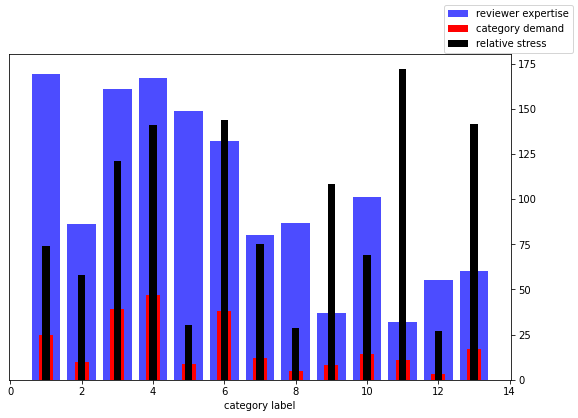

In [15]:
# Make a bar plot of all the proposal categories and numerical reviewer expertise 

all_topics_list = []
all_topics_count = np.zeros(df_rev_score.transpose()[1:-1].shape[0])

for idx, topic_set in enumerate(df_cat['Category_List']): # run through each proposal
    #print(idx, topic_set)
    for topic in topic_set: # run through each topic in each proposal
        all_topics_count[topic-1] += 1 # add one to the demand per mention
        #print(topic, df_rev_score[topic][1])
        all_topics_list.append(topic)
        
fig, ax = plt.subplots()#figsize=(16,8))

ax.bar(range(1, rev_scores.shape[0]+1), [row.sum() for row in rev_scores], alpha=0.7, label = 'reviewer expertise', color='b')
ax.bar(range(1,rev_scores.shape[0]+1), all_topics_count, label = 'category demand', color = 'r', width=0.4)
#ax.hist(np.array(all_topics_list), histtype='step', linewidth=3, align='mid', bins=1000, label = 'category demand')

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.bar(range(1,rev_scores.shape[0]+1), 5*10**2*np.array(all_topics_count)[0:13]/[row.sum() for row in rev_scores][0:13], width=0.2, label = 'relative stress', color='k')

fig.legend()
plt.xlabel('category label')
plt.savefig('relative_stress.png')

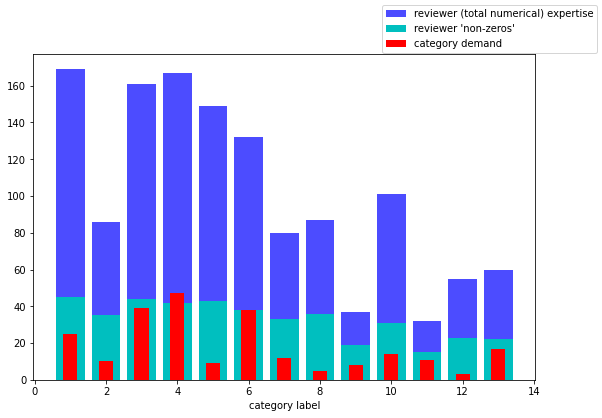

In [16]:
# Make a bar plot of all the proposal categories and binary reviewer expertise 
    
fig, ax = plt.subplots()
ax.bar(range(1,14), [row.sum() for row in rev_scores], alpha=0.7, label = 'reviewer (total numerical) expertise', color='b')
ax.bar(range(1, rev_scores.shape[0]+1), [row.sum() for row in zeroes_mask], label = 'reviewer \'non-zeros\'', color='c')
ax.bar(range(1,rev_scores.shape[0]+1), all_topics_count, label = 'category demand', color = 'r', width=0.4)

plt.xlabel('category label')
fig.legend()
plt.show()

## Affinity Matrix

In [17]:
# ---------------
# AFFINITY MATRIX
# ---------------

# create the affinity matrix
affinity = np.zeros((len(df_rev_score),len(df_cat)))

print('creation done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])
#affinity

# set the affinity to the MAXimum of ANY keyword
max = 0
for row_idx, row in enumerate(affinity):
    #print(row_idx, row)
    #for cell_idx, cell in enumerate(row):
    for cell_idx, topic_set in enumerate(df_cat['Category_List']):
        #print(topic_set, cell_idx)
        for topic in topic_set:
            #print(topic)
            max = np.maximum(max, rev_scores[topic-1][row_idx])
            #if ((topic != 14) and (topic != 15)): 
                #max = np.maximum(max, df_rev_score[topic][row_idx+1])
            # NOTE only consider the 13 subject categories 
        affinity[row_idx, cell_idx] = max/10 # normalise to between 0 and 1
        max=0
        
print('set up affinities done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])
print(affinity[45])
#-----------        
     
# Set constraints in the affinity matrix :
# i.e. 1. Maximum over observation categories 
#      2. Make sure there are not zeros in EVERY category, 
#      3. reviewer/proposal conflicts (science_cross_check)
# by setting affinity to 0 (which is actually a soft constraint, but wusually suffices)

# Observation Category
rev_obs_cat = np.genfromtxt('reviewer_observation_expertise_MKT-22.csv', delimiter=',', skip_header=1)
prop_obs_cat = np.genfromtxt('proposal_observation_categories_MKT-22.csv', delimiter=',', skip_header=1)[:,1]
#print(prop_obs_cat)
        
for row_idx, row in enumerate(rev_obs_cat):
    #print (rev_obs_cat[row_idx][1:])
    for col_idx, col in enumerate(prop_obs_cat):
        #print (row_idx, col_idx, col, row[1:])
        if row[int(col)] == 0: 
            #print (affinity[row_idx][col_idx])
            affinity[row_idx][col_idx] = 0.
print('Obs cat done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])

            
# check there is at least one non-zero
'''set_zero = False
for row_idx, row in enumerate(affinity):#row_idx is reviewer ID
    for cell_idx, topic_set in enumerate(df_cat['Category_List']):#cell_idx is the proposal id, topic_set is the list of topics
        for topic in topic_set:
            if df_rev_score[topic][row_idx]==0.: set_zero = True # if there are ANY '0' experience ratings
        if set_zero == True: affinity[row_idx, cell_idx] = 0.
        set_zero = False

print('at least one nonzero done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])
'''

# mask out conflicts of interest:
affinity = affinity*conflict_mask
print('set conflicts done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])

creation done (47, 132) zeros: 6204 of 6204
set up affinities done (47, 132) zeros: 851 of 6204
[0.  0.1 0.3 0.3 0.3 0.3 0.1 0.1 0.5 0.3 0.3 0.5 0.5 0.5 0.4 0.1 0.  0.3
 0.1 0.3 0.4 0.1 0.5 0.1 0.5 0.3 0.2 0.2 0.3 0.5 0.3 0.  0.1 0.3 0.5 0.3
 0.1 0.5 0.5 0.3 0.3 0.5 0.5 0.5 0.5 0.1 0.3 0.4 0.4 0.4 0.5 0.3 0.1 0.4
 0.3 0.1 0.5 0.1 0.5 0.3 0.5 0.4 0.3 0.4 0.3 0.2 0.4 0.5 0.1 0.3 0.5 0.3
 0.3 0.1 0.  0.3 0.5 0.4 0.3 0.  0.4 0.1 0.3 0.4 0.3 0.5 0.1 0.3 0.3 0.1
 0.5 0.4 0.1 0.5 0.1 0.3 0.4 0.3 0.3 0.4 0.1 0.5 0.4 0.1 0.1 0.5 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.5 0.4 0.5 0.3 0.4 0.3 0.2 0.3 0.1 0.1 0.1
 0.1 0.  0.3 0.4 0.2 0.4]
Obs cat done (47, 132) zeros: 1638 of 6204
set conflicts done (47, 132) zeros: 1724 of 6204


In [18]:
##SCRATCH
print(np.count_nonzero(affinity[12]))#, affinity[12] )
#print( np.count_nonzero(1-conflict_mask[12]), 1-conflict_mask[12])
#print(affinity[21], np.count_nonzero(affinity[21]), conflict_mask[21], np.count_nonzero(conflict_mask[21]))

#pd.DataFrame(affinity).to_csv('affinity.csv')
print(affinity.shape, affinity[12])
og_rev_idx[12], og_rev_idx

118
(47, 132) [0.  0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.2 0.3 0.3 0.3 0.3 0.  0.3
 0.3 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.  0.  0.3 0.2 0.3 0.  0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.2 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.  0.3 0.2 0.3 0.2 0.3 0.3 0.  0.3 0.3 0.1 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.  0.3 0.3 0.3 0.2 0.  0.  0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.  0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.2
 0.3 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.1 0.3 0.3 0.2 0.3
 0.3 0.  0.3 0.3 0.  0.3]


(21,
 array([ 2,  4,  6,  7,  9, 10, 12, 13, 14, 15, 17, 19, 21, 26, 27, 28, 29,
        31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
        48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61]))

In [24]:
## Make some UBER reviewers

affinity[12] = affinity[1] = 0.6*np.ones(n_p)
affinity[12]

array([0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6])

## Prepare arrays for LP

In [26]:
# --------------------------------------------------------------------------------------------
# convert arrays to a set of stored numpy arrays for the Linear Program (LP) optimisation code
# --------------------------------------------------------------------------------------------

# assign the maximum number of proposals per reviewer
loads = np.genfromtxt('science_max_reviews.csv', skip_header=1, delimiter=',')[:,1]

# set the lower bound of proposals to review to be 10
loads_lb = 10*np.ones(affinity.shape[0])

# set the coverage (i.e. number of reviews per paper) to be exactly 4
covs = 4*np.ones(affinity.shape[1])

loads_lb.shape

(47,)

-------------------------------------------------

In [27]:
# save array to disk, to transfer to server with Gurobi license
np.save('scores.npy', affinity)
np.save('loads.npy', loads)
np.save('loads-lb.npy', loads_lb)
np.save('covs.npy', covs)

### Note: move to sherlock

+ copy over scores.npy (the storage name of the afinity matrix) to sherlock.sdp.kat.ac.za (which has the gurobi license file):
`
rsync -avz scores.npy richarms@sherlock.sdp.kat.ac.za:/home/richarms/src/fair-matching/data/mk/
`
+ then:
`ssh sherlock.sdp.kat.ac.za`
+ run the linear program
`
cd /home/richarms/src/fair-matching
source venv/bin/activate
source bin/setup.sh
sh bin/exp/basic.sh config/mk/basic-lb.json
exit
`
+ and copy back the assignment.npy 

`rsync -avz richarms@sherlock.sdp.kat.ac.za:/home/richarms/src/fair-matching/exp_out/mk/basic-lb/{DATE}/results/assignment.npy .`

## Code to evaluate LP result


In [28]:
# load the assignment matrix from the LP
# The assignment matrix is a sparse binary array of dim n_reviewers * n_proposals 
# with nonzero entries for a positive assignment
assignment = np.load('assignment.npy')
assignment = assignment.astype(int)

In [29]:
## CHECK
## Sanity check -- check that the trace of the affinity and assignment match that produced by LP
np.sum(np.diag(np.matmul(np.transpose(affinity), assignment))), np.trace(np.matmul(np.transpose(affinity), assignment))

(302.9, 302.9)

In [30]:
# SCRATCH
print(np.count_nonzero(np.transpose(assignment)[0]))
print(np.transpose(assignment)[0])
print(np.count_nonzero((assignment)[12]))
print((assignment)[12])

4
[1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
20
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0
 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0]


In [31]:
# Gene Matrix
################

# The assignment matrix may be expressed as a 'gene matrix' (an inherited term): a dense array 
# of reviewers assigned to each proposal, (as opposed to the assignment matrix, which is a sparse binary 
# array of dim n_reviewers * n_proposals with nonzero entries for a positive assignment)
gene_matrix = np.zeros((n_proposals, coverage))
gene_matrix_indexes = np.zeros((n_proposals, coverage))

# The reviewer_assignment is the logical opposite of the gene matrix: for each reviewer,
# it is a list of their associated proposals
reviewer_assignment = np.empty((n_reviewers), dtype=object)

# original reviewer index
og_rev_idx = np.array(df_rev_score['CATEGORY ID'])

# set the first element of the reviewer assignment vector to be the original reviewer 
# index, as a string
for idx, r in enumerate(reviewer_assignment):
    reviewer_assignment[idx] = str(og_rev_idx[idx])



for col_idx, col in enumerate(assignment.transpose()):
    # set the gene matrix to the indices of each non-zero element in the assignment
    gene_matrix[col_idx] = np.nonzero(col)[0]
    # set up the correct original reviewer IDs
    for rev_idx, rev in enumerate(gene_matrix[col_idx]):
        gene_matrix_indexes[col_idx][rev_idx] = og_rev_idx[int(rev)]
    # augment the string with each fo the {n_min, n_max} proposals that reviewer should review
    for i in np.nonzero(col)[0]:
        reviewer_assignment[i] = reviewer_assignment[i] + ', ' + df_cat['PSS ID'][col_idx]

gene_matrix = gene_matrix.astype(int)

print("This is the LP result, expressed as a set of (4) reviewers (by original ID) per proposal: \n", 
      np.column_stack((df_cat['PSS ID'], gene_matrix_indexes.astype(int))))

print(reviewer_assignment)


This is the LP result, expressed as a set of (4) reviewers (by original ID) per proposal: 
 [['MKT-22003' 2 4 21 32]
 ['MKT-22004' 27 38 51 55]
 ['MKT-22005' 6 19 28 36]
 ['MKT-22006' 28 33 37 57]
 ['MKT-22007' 15 17 53 58]
 ['MKT-22008' 35 37 57 58]
 ['MKT-22009' 12 27 52 54]
 ['MKT-22011' 9 12 27 55]
 ['MKT-22012' 7 34 49 56]
 ['MKT-22013' 10 31 33 36]
 ['MKT-22015' 6 26 36 58]
 ['MKT-22016' 40 42 53 59]
 ['MKT-22017' 13 29 41 55]
 ['MKT-22018' 29 34 48 61]
 ['MKT-22019' 14 40 42 50]
 ['MKT-22020' 9 38 44 52]
 ['MKT-22022' 4 14 21 42]
 ['MKT-22023' 27 38 44 51]
 ['MKT-22025' 9 44 46 52]
 ['MKT-22027' 15 17 31 53]
 ['MKT-22028' 14 21 42 50]
 ['MKT-22029' 9 46 51 52]
 ['MKT-22030' 13 41 49 59]
 ['MKT-22032' 9 46 52 54]
 ['MKT-22033' 7 13 49 59]
 ['MKT-22034' 2 10 26 28]
 ['MKT-22035' 2 19 32 43]
 ['MKT-22036' 2 19 31 43]
 ['MKT-22037' 6 10 33 37]
 ['MKT-22038' 17 31 35 59]
 ['MKT-22039' 6 33 36 43]
 ['MKT-22040' 4 13 21 40]
 ['MKT-22042' 9 44 46 51]
 ['MKT-22043' 2 6 19 58]
 ['MKT-2204

In [32]:
# Save proposal assignments and reviewer assignemnts to CSV files
pd.DataFrame(np.column_stack((df_cat['PSS ID'], gene_matrix_indexes.astype(int)))).to_csv('Proposal_assignment.csv')
pd.DataFrame(np.column_stack((og_rev_idx, reviewer_assignment))).to_csv('Reviewer_assignment.csv')

In [33]:
# Check for category conflicts
# this code block determines how many reviews are assigned where the assigned reviewer is reviewing outside of their stated HI/Cont prference area

match_mask = np.empty(n_reviewers, dtype=object)
match_mask = np.ones((n_reviewers,20))
'''for i, row in enumerate(rev_match_hi_cont):
    r=np.fromstring(row[3:], sep=',')
    match_mask[i][0:r.shape[0]] = r'''

match_mask = match_mask.astype(int)
# np.count_nonzero(match_mask), match_mask.flatten().shape

# print out for the .csv
print("Rev ID, primary HI/Cont score, secondary HI/Cont score, number of proposals outside expertise area")
for i,row in enumerate(match_mask):
    if ((20-np.count_nonzero(row)) > 0): #ignore if there are none
        print(i+1, int(np.max(rev_scores[13:15].transpose()[i])), int(np.min(rev_scores[13:15].transpose()[i])), 20-np.count_nonzero(row))

print("Number of assigned reviews where the assigned reviewer is reviewing outside of their stated HI/Cont prference area: ", match_mask.flatten().shape[0] - np.count_nonzero(match_mask), "out of ", np.count_nonzero(assignment))

Rev ID, primary HI/Cont score, secondary HI/Cont score, number of proposals outside expertise area
Number of assigned reviews where the assigned reviewer is reviewing outside of their stated HI/Cont prference area:  0 out of  528


Fernando's matrix zeros:  22
Fernando's Extended zeros:  90
Fernando's matrix: mean, median, minimum sum: 6.0 5.3731060606060606 6
[[4 0 0 2 'MKT-22003']
 [6 6 6 6 'MKT-22004']
 [5 5 6 6 'MKT-22005']
 [6 6 6 5 'MKT-22006']
 [5 6 6 6 'MKT-22007']
 [6 6 5 6 'MKT-22008']
 [6 6 6 6 'MKT-22009']
 [6 6 6 6 'MKT-22011']
 [6 4 4 6 'MKT-22012']
 [5 5 6 6 'MKT-22013']
 [5 6 6 6 'MKT-22015']
 [4 6 6 5 'MKT-22016']
 [6 6 6 6 'MKT-22017']
 [6 5 6 6 'MKT-22018']
 [6 6 6 6 'MKT-22019']
 [6 6 6 6 'MKT-22020']
 [0 5 0 6 'MKT-22022']
 [6 6 6 6 'MKT-22023']
 [6 6 6 6 'MKT-22025']
 [5 6 5 6 'MKT-22027']
 [6 3 6 6 'MKT-22028']
 [6 6 6 6 'MKT-22029']
 [6 6 4 5 'MKT-22030']
 [6 6 6 6 'MKT-22032']
 [6 6 4 5 'MKT-22033']
 [6 5 6 6 'MKT-22034']
 [6 5 5 6 'MKT-22035']
 [6 5 5 6 'MKT-22036']
 [5 5 6 6 'MKT-22037']
 [6 5 6 5 'MKT-22038']
 [5 6 6 6 'MKT-22039']
 [0 5 0 6 'MKT-22040']
 [6 6 6 6 'MKT-22042']
 [6 5 5 6 'MKT-22043']
 [6 6 6 5 'MKT-22044']
 [6 5 6 6 'MKT-22045']
 [6 6 6 6 'MKT-22046']
 [6 6 6 5 'MKT-220

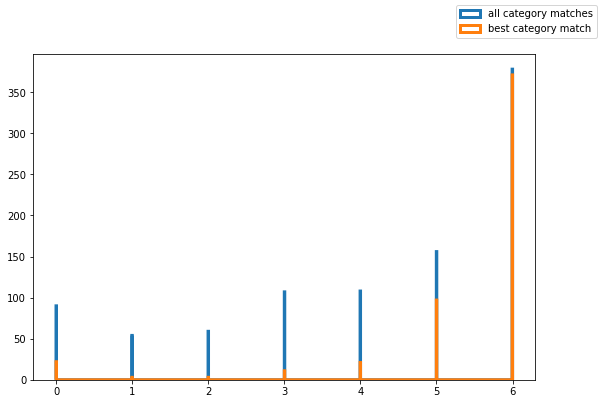

In [34]:
# -----------
# Fernando's Matrix 
# -----------

# max reviewer score matrix ('Fernando's Matrix')
rev_max_arr = np.zeros((n_p, 4))
hi_cont_arr = np.zeros((n_p, 4))
# all reviewer score list ('Extended Fernando's List')
all_assigned_affinities = []
all_hicont_scores = []


for cell_idx, topic_set in enumerate(df_cat['Category_List']):#iterate over proposals
    rev_a = np.zeros(4)
    hi_a = np.zeros(4)
    for topic in topic_set: #iterate over topic proposals
        if (topic <= 13):
            for rev_idx, rev in enumerate(gene_matrix[cell_idx]):#iterate over reviewers
                rev_a[rev_idx] = np.maximum(rev_a[rev_idx], rev_scores[topic-1][rev])
                all_assigned_affinities.append(rev_scores[topic-1][rev])
                #print(cell_idx, topic, rev_idx, rev, rev_scores[topic-1][rev])
        else:
            for rev_idx, rev in enumerate(gene_matrix[cell_idx]):#iterate over reviewers
                hi_a[rev_idx] = np.maximum(hi_a[rev_idx], rev_scores[topic-1][rev])
                all_hicont_scores.append(rev_scores[topic-1][rev])
        
    #print(rev_a.astype(int))#, hi_a.astype(int))
    rev_max_arr[cell_idx] = rev_a
    hi_cont_arr[cell_idx] = hi_a
    
print('Fernando\'s matrix zeros: ', rev_max_arr.flatten().shape[0] - np.count_nonzero(rev_max_arr))
print('Fernando\'s Extended zeros: ', len(all_assigned_affinities) - np.count_nonzero(np.array(all_assigned_affinities)))

fig, ax = plt.subplots()
ax.hist(all_assigned_affinities, histtype='step', linewidth=3, bins=1000, label='all category matches')
ax.hist(rev_max_arr.astype(int).flatten(), histtype='step', linewidth=3, bins=1000, label='best category match')#.sum(axis=0)
fig.legend()

#print('Extended: mean, median:', np.mean(all_assigned_affinities), np.median(all_assigned_affinities))
#print(np.sum(all_assigned_affinities), len(all_assigned_affinities), np.sum(all_assigned_affinities)/len(all_assigned_affinities))

rev_max_arr = rev_max_arr.astype(int)
print('Fernando\'s matrix: mean, median, minimum sum:', np.median(rev_max_arr), np.mean(rev_max_arr), np.min(rev_max_arr.sum(axis=1)))
#print('argmin: ', np.argmin(rev_max_arr.sum(axis=1)), ',sum: ', rev_max_arr.sum(axis=1))
#print(rev_max_arr.sum(axis=0))
print(np.column_stack((rev_max_arr, df_cat['PSS ID'])))


plt.savefig('Fernandos_hist.png')
plt.show()

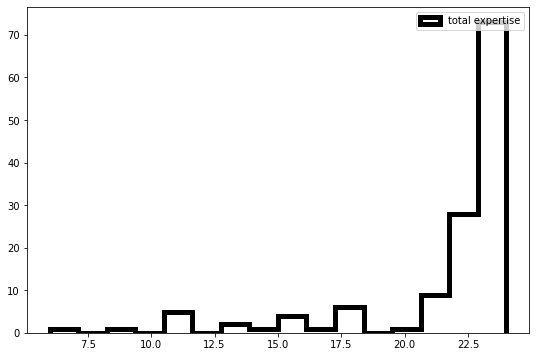

array([[6, 'MKT-22003'],
       [24, 'MKT-22004'],
       [22, 'MKT-22005'],
       [23, 'MKT-22006'],
       [23, 'MKT-22007'],
       [23, 'MKT-22008'],
       [24, 'MKT-22009'],
       [24, 'MKT-22011'],
       [20, 'MKT-22012'],
       [22, 'MKT-22013'],
       [23, 'MKT-22015'],
       [21, 'MKT-22016'],
       [24, 'MKT-22017'],
       [23, 'MKT-22018'],
       [24, 'MKT-22019'],
       [24, 'MKT-22020'],
       [11, 'MKT-22022'],
       [24, 'MKT-22023'],
       [24, 'MKT-22025'],
       [22, 'MKT-22027'],
       [21, 'MKT-22028'],
       [24, 'MKT-22029'],
       [21, 'MKT-22030'],
       [24, 'MKT-22032'],
       [21, 'MKT-22033'],
       [23, 'MKT-22034'],
       [22, 'MKT-22035'],
       [22, 'MKT-22036'],
       [22, 'MKT-22037'],
       [22, 'MKT-22038'],
       [23, 'MKT-22039'],
       [11, 'MKT-22040'],
       [24, 'MKT-22042'],
       [22, 'MKT-22043'],
       [23, 'MKT-22044'],
       [23, 'MKT-22045'],
       [24, 'MKT-22046'],
       [23, 'MKT-22047'],
       [23, '

In [35]:
plt.hist(rev_max_arr.sum(axis=1), histtype='step', bins=16, linewidth=5, color='k',label='total expertise')
plt.legend()
plt.show()
np.column_stack((rev_max_arr.sum(axis=1),df_cat['PSS ID']))
#rev_max_arr.sum(axis=1)

528
[ 4 20]


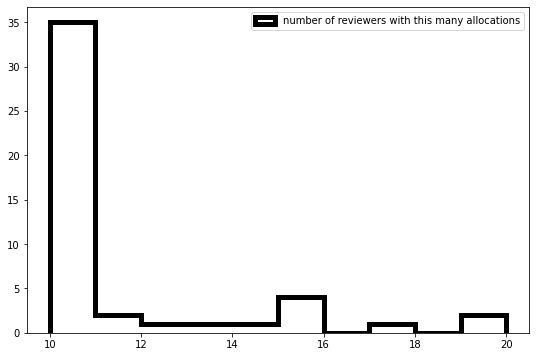

In [44]:
#column sums of the assignment: number of reviews per reviewer
col_sum=[]
print(np.count_nonzero(assignment))
for el in assignment:
    col_sum.append(np.count_nonzero(el))#print(np.count_nonzero(el))

print(np.column_stack((og_rev_idx,col_sum))[1])

plt.hist(col_sum, histtype='step', linewidth=5, color='k',label='number of reviewers with this many allocations')
plt.legend()
plt.savefig('reviewers_hist.png')


In [37]:
# check for conflicts of interest in final assignment

icm = np.where(conflict_mask == 1, 0, 1)
#zeroes_mask = np.where(np.array(df_rev_score.transpose()) > 0., 1, 0)[1:-1]
final_conflicts = assignment * icm
print('final conflicts:', np.count_nonzero(final_conflicts))
#icm[6], conflict_mask[6]

final conflicts: 0


Fernando's (random) matrix zeros:  69
Fernando's (random) Extended zeros:  196
Random Extended: mean, median 2.721638655462185 3.0
2591.0 952 2.721638655462185
Random: mean, median 3.0 3.3958333333333335 0.0 459 756


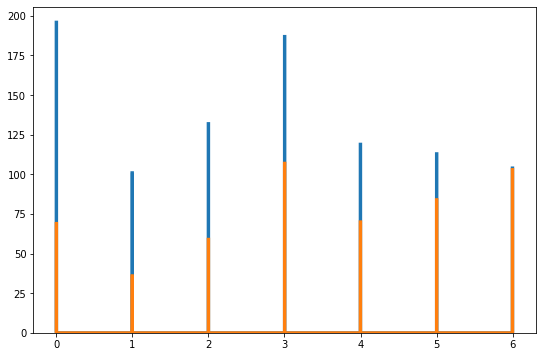

In [38]:
# VERIFICATION:
# Essentially this answers the question of what would be the base case? 
# What distribution of scores would a random assignment yield?

# -----------
# RANDOM Fernando's Matrix (reviewer score distribution)
# -----------

# random gene_matrix
r_gene_matrix = np.random.randint(0, n_r, size=(n_p,4))
r_gene_matrix+1

# max reviewer score matrix ('Fernando's Matrix')
rev_max_arr = np.zeros((n_p, 4))
# all reviewer score list ('Extended Fernando's List')
all_assigned_affinities = []


for cell_idx, topic_set in enumerate(df_cat['Category_List']):#iterate over proposals
    rev_a = np.zeros(4)
    for topic in topic_set: #iterate over topic proposals
        #if ((topic != 14) and (topic != 15)):
        if (topic <= 13):
            for rev_idx, rev in enumerate(r_gene_matrix[cell_idx]):#iterate over reviewers
                rev_a[rev_idx] = np.maximum(rev_a[rev_idx], rev_scores[topic-1][rev])
                all_assigned_affinities.append(rev_scores[topic-1][rev])
                #print(cell_idx, topic, rev_idx, rev, rev_scores[topic-1][rev])
                
    #print(rev_a)
    rev_max_arr[cell_idx] = rev_a
    
print('Fernando\'s (random) matrix zeros: ', rev_max_arr.flatten().shape[0] - np.count_nonzero(rev_max_arr))
print('Fernando\'s (random) Extended zeros: ', len(all_assigned_affinities) - np.count_nonzero(np.array(all_assigned_affinities)))

plt.hist(all_assigned_affinities, histtype='step', linewidth=3, bins=1000)

print('Random Extended: mean, median', np.mean(all_assigned_affinities), np.median(all_assigned_affinities))
print(np.sum(all_assigned_affinities), len(all_assigned_affinities), np.sum(all_assigned_affinities)/len(all_assigned_affinities))

np.mean(rev_max_arr.sum(axis=1))

plt.hist(rev_max_arr.astype(int).flatten(), histtype='step', linewidth=3, bins=1000)#.sum(axis=0)
print('Random: mean, median',np.median(rev_max_arr), np.mean(rev_max_arr), np.min(rev_max_arr.sum(axis=1)), np.count_nonzero(rev_max_arr.astype(int).flatten()), np.count_nonzero(all_assigned_affinities))

plt.savefig('random_hist.png')

Fernando's matrix zeros:  1
Fernando's Extended zeros:  63
Extended: mean, median 4.305672268907563 5.0
6.0 5.545454545454546 10.0 527 889


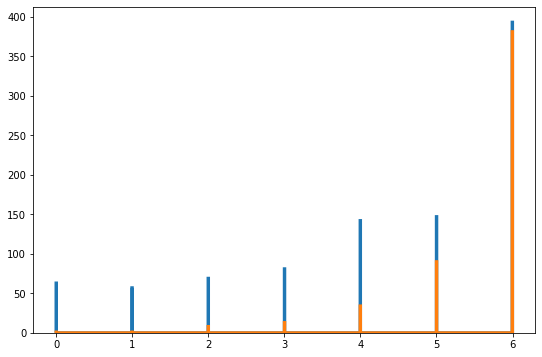

In [39]:
# -----------
# FAIR Fernando's Matrix (reviewer score distribution)
# -----------
fair_assignment = np.load('FAIR_assignment.npy')

# Express/Print the assignment matrix as a gene matrix
f_gene_matrix = np.zeros((n_p, 4))

for col_idx, col in enumerate(fair_assignment.transpose()):
    f_gene_matrix[col_idx] = np.nonzero(col)[0]

f_gene_matrix = f_gene_matrix.astype(int)    
#print(f_gene_matrix)

# max reviewer score matrix ('Fernando's Matrix')
rev_max_arr = np.zeros((n_p, 4))
# all reviewer score list ('Extended Fernando's List')
all_assigned_affinities = []


for cell_idx, topic_set in enumerate(df_cat['Category_List']):#iterate over proposals
    rev_a = np.zeros(4)
    for topic in topic_set: #iterate over topic proposals
        #if ((topic != 14) and (topic != 15)):
        if (topic <= 13):
            for rev_idx, rev in enumerate(f_gene_matrix[cell_idx]):#iterate over reviewers
                rev_a[rev_idx] = np.maximum(rev_a[rev_idx], rev_scores[topic-1][rev])
                all_assigned_affinities.append(rev_scores[topic-1][rev])
                #print(cell_idx, topic, rev_idx, rev, rev_scores[topic-1][rev])
                
    #print(rev_a)
    rev_max_arr[cell_idx] = rev_a
    
print('Fernando\'s matrix zeros: ', rev_max_arr.flatten().shape[0] - np.count_nonzero(rev_max_arr))
print('Fernando\'s Extended zeros: ', len(all_assigned_affinities) - np.count_nonzero(np.array(all_assigned_affinities)))

plt.hist(all_assigned_affinities, histtype='step', linewidth=3, bins=1000)

print('Extended: mean, median', np.mean(all_assigned_affinities), np.median(all_assigned_affinities))
#print(np.sum(all_assigned_affinities), len(all_assigned_affinities), np.sum(all_assigned_affinities)/len(all_assigned_affinities))

#rev_max_arr

plt.hist(rev_max_arr.astype(int).flatten(), histtype='step', linewidth=3, bins=1000)#.sum(axis=0)
print(np.median(rev_max_arr), np.mean(rev_max_arr), np.min(rev_max_arr.sum(axis=1)), np.count_nonzero(rev_max_arr.astype(int).flatten()), np.count_nonzero(all_assigned_affinities))